In [1]:
#importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from lib import *
import pandas as pd
import pennylane as qml
from lib.cr2dataset import hartree, get_pot_cr2
from lib.cr2dataset import cr2_params
from lib.qpe import QPE 
from lib.phase_estimation import *


# Part 1 Hamiltonian Generation
### 1.1 : Interpotential Curve Point Selection

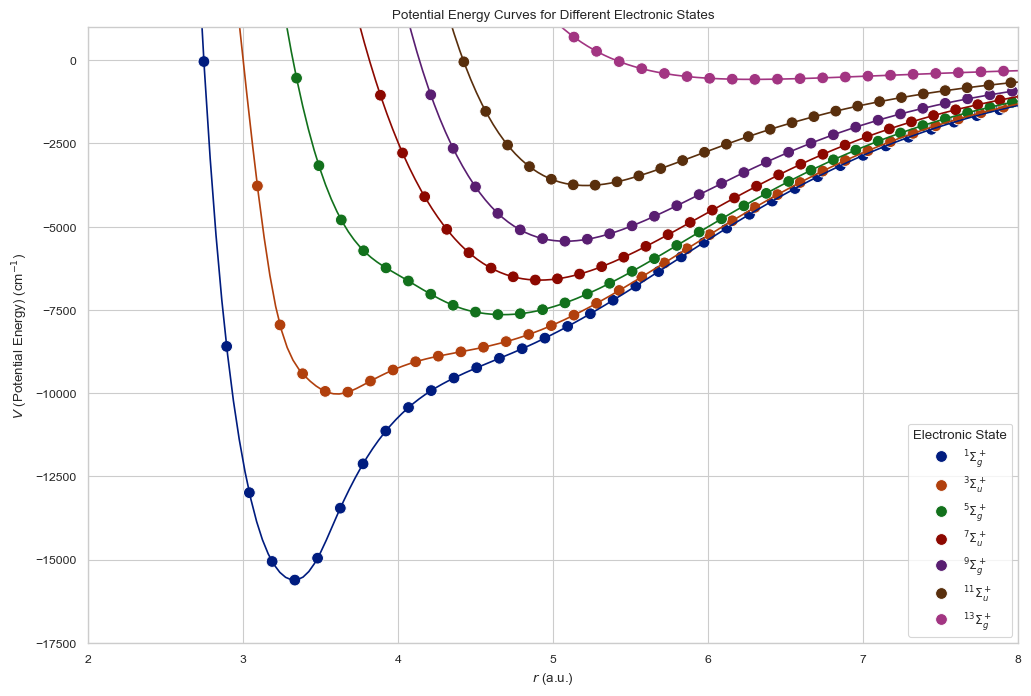

In [2]:
# Set the Seaborn theme and color palette
sns.set_theme(context='paper', style='whitegrid')
dark_palette = sns.color_palette("dark", n_colors=7)  # Using a darker palette

# Initialize DataFrame to store the potential data
data_32 = pd.DataFrame()
data_1000 = pd.DataFrame()
states = [1, 3, 5, 7, 9, 11, 13]
labels = ['${}^1\Sigma_g^+$', '${}^3\Sigma_u^+$', '${}^5\Sigma_g^+$', '${}^7\Sigma_u^+$',
          '${}^9\Sigma_g^+$', '${}^{11}\Sigma_u^+$', '${}^{13}\Sigma_g^+$']

# Fetch potential data for each state and accumulate it in the DataFrames
for i, state in enumerate(states):
    pot, lims = get_pot_cr2(state)
    rs_1000 = np.linspace(lims[0], lims[1], 1000)
    rs_32 = np.linspace(start=lims[0], stop=lims[1], num=256)
    potentials_32 = pot(rs_32) * hartree
    potentials_1000 = pot(rs_1000) * hartree
    temp_df_32 = pd.DataFrame({'r (a.u.)': rs_32, 'V (cm^-1)': potentials_32, 'State': labels[i]})
    temp_df_1000 = pd.DataFrame({'r (a.u.)': rs_1000, 'V (cm^-1)': potentials_1000, 'State': labels[i]})
    data_32 = pd.concat([data_32, temp_df_32], ignore_index=True)
    data_1000 = pd.concat([data_1000, temp_df_1000], ignore_index=True)


plt.figure(figsize=(12, 8))
sns.lineplot(
    data=data_1000,
    x='r (a.u.)',
    y='V (cm^-1)',
    hue='State',
    palette=dark_palette,
    legend=None
)


sns.scatterplot(
    data=data_32,
    x='r (a.u.)',
    y='V (cm^-1)',
    hue='State',
    palette=dark_palette,
    s=72,  # Adjust the size of the scatter plot markers
    edgecolor="w",
    legend='full'
)

# Configure plot aesthetics 
plt.ylim((-17500, 1000))
plt.xlim((2, 8))
plt.xlabel(r'$r$ (a.u.)')
plt.ylabel(r'$V$ (Potential Energy) (cm$^{-1}$)')
plt.title('Potential Energy Curves for Different Electronic States')
plt.legend(title='Electronic State', loc='lower right')

# Display the plot
plt.show()




### 1.2: Generating the Hamiltonians for all Spin States



In [3]:

mol_params =  cr2_params
list_of_spins = [1, 3, 5, 7, 9, 11, 13]
list_of_params32 = [[2.8, 4], [3.2, 4.5], [4, 6.5], [4.3, 6.8], [4.5, 7], [4.6, 7], [5.2, 9]]

hamiltonians = create_hamiltonians(list_of_spins, list_of_params32, mol_params=mol_params)

for i, spin in enumerate(list_of_spins):
    params = list_of_params32[i]
    variable_name = f"h_dvr_{spin}"
    decomposed_hamiltonian = qml.pauli_decompose(hamiltonians[(spin, tuple(params))])
    globals()[variable_name] = decomposed_hamiltonian




### 1.3 Conversion of the hamiltonians into a unitary matrix 

In [4]:
wire_order = [0, 1, 2, 3, 4]
n = 5 

for spin in list_of_spins:
    variable_name = f"ufss{spin}"
    hamiltonian = globals()[f"h_dvr_{spin}"]
    unitary = convert_to_unitary(hamiltonian, n, wire_order)
    globals()[variable_name] = unitary
    



## 1.4 Find the true phases of the unitary matrices 

In [5]:
for spin in list_of_spins:
    unitary_matrix = globals()[f"ufss{spin}"]
    phase = find_true_phases(unitary_matrix)
    globals()[f"phase{spin}"] = phase



In [9]:
for spin in list_of_spins:
    phase = globals()[f"phase{spin}"]
    print(phase.shape)
    print(f"True phases for spin state {spin}: {phase}")


(32,)
True phases for spin state 1: [2.59549852 2.82015023 4.14564812 3.97573088 3.09402836 3.3004665
 3.35654465 3.5359787  3.59916729 3.56744009 1.99793971 1.85857196
 1.78986044 1.3646841  1.37820388 1.14608019 1.17811506 4.65813223
 0.66442732 0.42620769 0.36249903 0.23873364 0.07696209 6.26594892
 4.86267913 4.99756717 5.13939776 5.31181379 5.41901224 5.89244634
 5.7508709  5.76015802]
(32,)
True phases for spin state 3: [1.7941957  1.46774628 2.31559159 2.50036417 2.64359349 2.7429805
 2.86735117 3.07264139 3.06718925 3.70965212 3.68304999 4.10210444
 4.26420928 1.0235146  0.83747547 0.84459057 0.62205996 4.65048287
 0.349665   0.29971547 0.13378105 4.83056461 4.84514804 4.94100358
 4.92292686 5.31931122 5.49190608 5.76718727 5.70951889 5.72496728
 6.1300666  6.13959543]
(32,)
True phases for spin state 5: [5.45735995 5.86476762 0.17594593 0.13328536 6.05488304 6.11487859
 6.19932455 6.18314709 4.62189875 4.51676789 4.43670453 0.85597007
 0.91621739 0.99678194 2.13470788 1.999376

## Part 2 Quantum Circuit Generation for Phase Estimation
### 2.1 Obtaining Likelihood

In [38]:
unitary_matrices = [ufss1, ufss3, ufss5, ufss7, ufss9, ufss11, ufss13]



### INITALIZING THE UNITARY MATRICES AS A CUSTOM GATE IN PENNYLANE 


custom_gates = init_custom_gates(unitary_matrices)



gate_indices = range(1,7)
k = 1  
beta = 0.5 
wires = 11
estimation_wires = [5, 6, 7, 8, 9, 10]









[9.71291118e-01 4.55696534e-04 4.55696534e-04 4.55696534e-04
 4.55696534e-04 4.55696534e-04 4.55696534e-04 4.55696534e-04
 4.55696534e-04 4.55696534e-04 4.55696534e-04 4.55696534e-04
 4.55696534e-04 4.55696534e-04 4.55696534e-04 4.55696534e-04
 4.55696534e-04 4.55696534e-04 4.55696534e-04 4.55696534e-04
 4.55696534e-04 4.55696534e-04 4.55696534e-04 4.55696534e-04
 4.55696534e-04 4.55696534e-04 4.55696534e-04 4.55696534e-04
 4.55696534e-04 4.55696534e-04 4.55696534e-04 4.55696534e-04
 4.55696534e-04 4.55696534e-04 4.55696534e-04 4.55696534e-04
 4.55696534e-04 4.55696534e-04 4.55696534e-04 4.55696534e-04
 4.55696534e-04 4.55696534e-04 4.55696534e-04 4.55696534e-04
 4.55696534e-04 4.55696534e-04 4.55696534e-04 4.55696534e-04
 4.55696534e-04 4.55696534e-04 4.55696534e-04 4.55696534e-04
 4.55696534e-04 4.55696534e-04 4.55696534e-04 4.55696534e-04
 4.55696534e-04 4.55696534e-04 4.55696534e-04 4.55696534e-04
 4.55696534e-04 4.55696534e-04 4.55696534e-04 4.55696534e-04]
[9.76627145e-01 3.70997

### 2.2 Obtaining Posterior Distribution  